In [1]:
%matplotlib inline
import gc

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn
from torchsummary import summary

import util
import audio_ss_dataset
import base_nnio
import models.base_models

torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

print(device)



cpu


# Load Dataset

In [2]:
num_sources = 2

sr, duration = 8000, 2.0

np.random.seed(0)
source1 = np.load(f'datasets/voices_sr{sr}_dur{duration}.npy')
np.random.shuffle(source1)
source1 = torch.from_numpy(source1)

np.random.seed(0)
source2 = np.load(f'datasets/air_conditioning_sr{sr}_dur{duration}_num15000.npy')
np.random.shuffle(source2)
source2 = torch.from_numpy(source2)

audiossds_test = audio_ss_dataset.AudioSSDS(sr, duration, sources=(source1[:100], source2[:100]))
audiossds_train = audio_ss_dataset.AudioSSDS(sr, duration, sources=(source1[100:], source2[100:]))
audionnio = base_nnio.BaseNNIO(sr, duration)


x, y = audiossds_test[:1]
input_shape, output_shape = audionnio.audio_to_nn_input(x).shape, audionnio.audio_to_nn_output(y).shape
print('nn input shape: ', input_shape)
print('nn output shape: ', output_shape)

nn input shape:  torch.Size([1, 2, 151, 214])
nn output shape:  torch.Size([1, 2, 151, 214])


# Model Definitions

In [3]:
model_g = models.base_models.FTCNNGenerator(2, [6, 6, 6, 6], 
                         num_layers_per_block=4, block_gr=24).to(device, dtype)
# model_g = torch.load('models/ftnn_naive_epochs300.pth')
summary(model_g, input_size=input_shape[1:])

model_d = models.base_models.FTCNNDiscrimminator(2, [6, 6, 6, 6], input_hw = input_shape[2:], 
                              num_layers_per_block=4, block_gr=24).to(device, dtype)
summary(model_d, input_size=input_shape[1:])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 151, 214]              18
       BatchNorm2d-2          [-1, 6, 151, 214]              12
              ReLU-3          [-1, 6, 151, 214]               0
            Conv2d-4         [-1, 24, 151, 214]           1,320
       BatchNorm2d-5         [-1, 30, 151, 214]              60
              ReLU-6         [-1, 30, 151, 214]               0
            Conv2d-7         [-1, 24, 151, 214]           6,504
       BatchNorm2d-8         [-1, 54, 151, 214]             108
              ReLU-9         [-1, 54, 151, 214]               0
           Conv2d-10         [-1, 24, 151, 214]          11,688
      BatchNorm2d-11         [-1, 78, 151, 214]             156
             ReLU-12         [-1, 78, 151, 214]               0
           Conv2d-13          [-1, 6, 151, 214]           4,218
  NeuralTransform-14          [-1, 6, 1

# Manual Method
Seperating the frequency manually from spectrogram

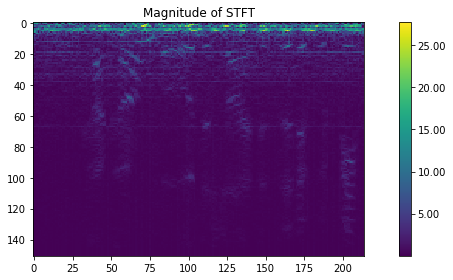

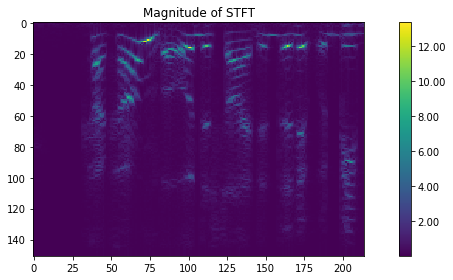

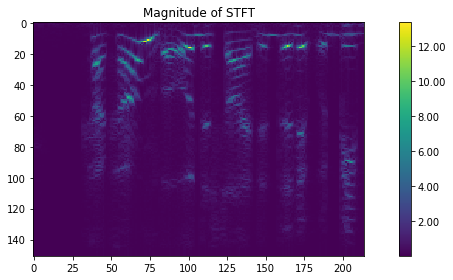

In [4]:
x, y = audiossds_test[:1]

audionnio.show_play_audio(x[0], ['mag', 'audio'])

audionnio.show_play_audio(y[0, 0], ['mag', 'audio'])

spectrogram = audionnio.audio_to_nn_output(y)

# can't use manual method with air conditioning noise
# spectrogram = audionnio.channels_to_complex(spectrogram)
# spectrogram[0, 30:34, :] = 0
# spectrogram = audionnio.complex_to_channels(spectrogram)

yp = audionnio.nn_output_to_audio(spectrogram, x, transform_X_batch=False)[0, 0]
audionnio.show_play_audio(yp, ['mag', 'audio'])


# Base Method

Make a neural network to just take out the tone

In [5]:
mse = nn.MSELoss()
bce = nn.BCELoss()

import pytorch_ssim

lambda_mse = 1.0
lambda_noise_weighted_mse = 0.0 #2.0
lambda_ssim = 0.0

def generator_loss_function_base(Y_batch_pred, Y_batch, X_batch):
    # normal MSE loss for now
    Y_batch_noise = X_batch-Y_batch
    Y_batch_noise_pred = X_batch-Y_batch_pred
    
    # normal mse loss
    loss_mse = lambda_mse * mse(Y_batch_pred, Y_batch)
    
    # noise weighted mse loss
    loss_noise_weighted_mse = lambda_noise_weighted_mse * torch.mean(((Y_batch_pred-Y_batch)**2) * torch.abs(Y_batch_noise))
    
    # SSIM loss
    loss_ssim = lambda_ssim * (2 - pytorch_ssim.ssim(Y_batch, Y_batch_pred) - pytorch_ssim.ssim(Y_batch_noise, Y_batch_noise_pred))
    
    # total loss
    loss = loss_mse + loss_noise_weighted_mse + loss_ssim
    print(f'{loss_mse}+{loss_noise_weighted_mse}+{loss_ssim}={loss}')
    
    return loss

In [6]:
X_test, Y_test = audiossds_test[:1]
X_test, Y_test = audionnio.audio_to_nn_input(X_test), audionnio.audio_to_nn_output(Y_test)
print(X_test.shape)
print(Y_test.shape)

torch.Size([1, 2, 151, 214])
torch.Size([1, 2, 151, 214])


In [7]:
with torch.no_grad():
    Y_test_pred = model_g(util.to_torch(X_test, device=device, dtype=dtype))

print('Test Loss: ', generator_loss_function_base(Y_test_pred, 
                                                  util.to_torch(Y_test, device=device, dtype=dtype), X_test).item())

0.4729490876197815+0.0+0.0=0.4729490876197815
Test Loss:  0.4729490876197815


Showing example:  0
Input:


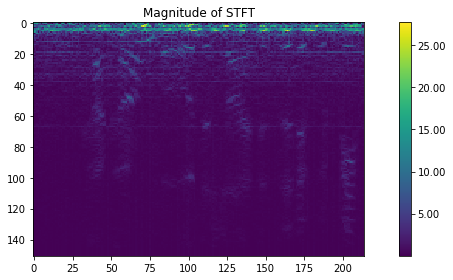

Target:


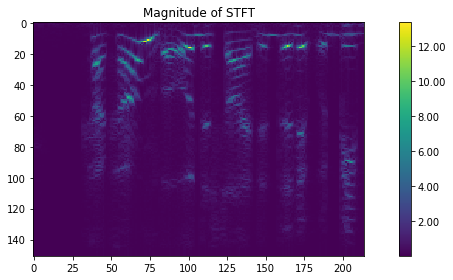

Output:


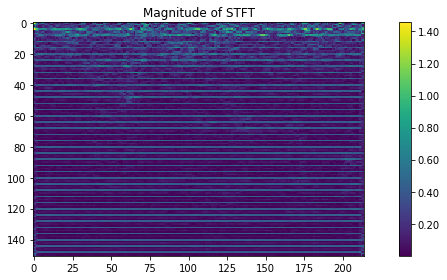

In [8]:
test_example_idx = 0
print('Showing example: ', test_example_idx)
print('Input:')
audionnio.show_play_nn_input(X_test, ['mag', 'audio'], sample_idx=test_example_idx)
print('Target:')
audionnio.show_play_nn_output(Y_test, X_test, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Output:')
audionnio.show_play_nn_output(Y_test_pred, X_test, ts=['mag', 'audio'], sample_idx=test_example_idx)

In [9]:
util.clear_mem(True)

In [10]:
%%time

torch.manual_seed(0)
np.random.seed(0)

num_epochs = 3
batch_size = 10
opt = torch.optim.Adam(model_g.parameters(), lr=0.001)

losses = []
epoch_pbar = tqdm(range(num_epochs), desc='Epochs')

model_g = model_g.train()
for epoch_idx in epoch_pbar:
    all_batch_indices = util.get_batch_indices(np.arange(len(audiossds_train)), batch_size)
    batch_pbar = tqdm(all_batch_indices, desc=f'Epoch {epoch_idx} Batches')
    for batch_idxs in batch_pbar:
        X_batch, Y_batch = audiossds_train[batch_idxs]
        X_batch, Y_batch = audionnio.audio_to_nn_input(X_batch), audionnio.audio_to_nn_output(Y_batch)
        X_batch, Y_batch = X_batch.to(device, dtype), Y_batch.to(device, dtype)

        opt.zero_grad()
        Y_batch_pred = model_g(X_batch)
        loss = generator_loss_function_base(Y_batch_pred, Y_batch, X_batch)
        loss.backward()
        opt.step()

        loss = loss.item()
        losses.append(loss)
        batch_pbar.set_postfix({'Loss':loss})
model_g = model_g.eval()

plt.plot(np.arange(len(losses)), losses)

del X_batch, Y_batch, Y_batch_pred, loss, losses

0.9731231331825256+0.0+0.0=0.9731231331825256
0.4751449525356293+0.0+0.0=0.4751449525356293
0.5115330815315247+0.0+0.0=0.5115330815315247
0.8329775929450989+0.0+0.0=0.8329775929450989
0.8093071579933167+0.0+0.0=0.8093071579933167
0.5821789503097534+0.0+0.0=0.5821789503097534
0.3958895802497864+0.0+0.0=0.3958895802497864
0.46907204389572144+0.0+0.0=0.46907204389572144
0.4297229051589966+0.0+0.0=0.4297229051589966
0.44952207803726196+0.0+0.0=0.44952207803726196
0.4143417477607727+0.0+0.0=0.4143417477607727
0.5280500054359436+0.0+0.0=0.5280500054359436
0.9253183603286743+0.0+0.0=0.9253183603286743
0.7921948432922363+0.0+0.0=0.7921948432922363
0.4094799757003784+0.0+0.0=0.4094799757003784
0.5731066465377808+0.0+0.0=0.5731066465377808
0.3394794166088104+0.0+0.0=0.3394794166088104
0.5009339451789856+0.0+0.0=0.5009339451789856
0.37685471773147583+0.0+0.0=0.37685471773147583
0.4711466133594513+0.0+0.0=0.4711466133594513
0.31078213453292847+0.0+0.0=0.31078213453292847
0.3131391108036041+0.0+0.0

KeyboardInterrupt: 

In [12]:
util.clear_mem(True)

In [14]:
with torch.no_grad():
    Y_test_pred = model_g(util.to_torch(X_test, device=device, dtype=dtype))

print('Test Loss: ', generator_loss_function_base(Y_test_pred, 
                                                  util.to_torch(Y_test, device=device, dtype=dtype), X_test).item())

0.22950437664985657+0.0+0.0=0.22950437664985657
Test Loss:  0.22950437664985657


Showing example:  0
Input:


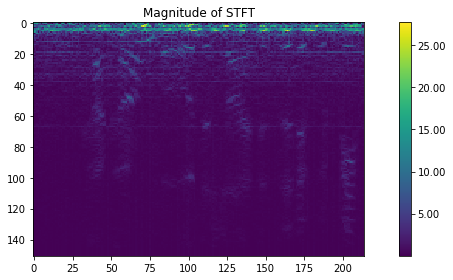

Target:


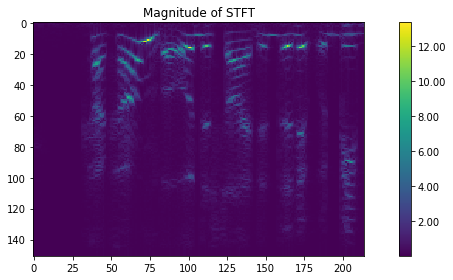

Output:


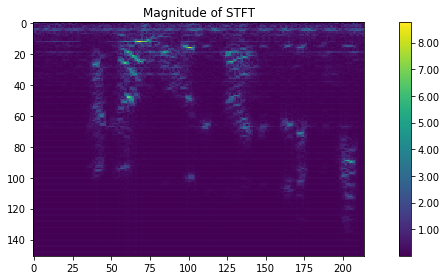

In [15]:
test_example_idx = 0
print('Showing example: ', test_example_idx)
print('Input:')
audionnio.show_play_nn_input(X_test, ['mag', 'audio'], sample_idx=test_example_idx)
print('Target:')
audionnio.show_play_nn_output(Y_test, X_test, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Output:')
audionnio.show_play_nn_output(Y_test_pred, X_test, ts=['mag', 'audio'], sample_idx=test_example_idx)

### Save the model

In [29]:
torch.save(model_g, f'models/model_g_base_big_epochs{3}.pth')

# Our Method

Generator-Discriminator setup (without GAN)

In [18]:
def discriminator_loss_function_base(real_out, fake_out):
    return bce(real_out, torch.ones_like(real_out)) + bce(fake_out, torch.zeros_like(fake_out))

def generator_loss_function_gan(X_batch, Y_batch, Y_batch_pred, model_d):
    Yp_batch = X_batch - Y_batch # the noise
    Yp_batch_pred = X_batch - Y_batch_pred
    
    d_Y_batch_pred = model_d(Y_batch_pred)
    d_Yp_batch_pred = model_d(Yp_batch_pred)
    
#     loss1 = mse_crit(Y_batch_pred, Y_batch)
#     loss2 = mse_crit(Yp_batch, Yp_batch_pred) # EXACT same the previous
    loss1 = 0.
    
    loss3 = bce(d_Y_batch_pred, torch.ones_like(d_Y_batch_pred))
    loss4 = bce(d_Yp_batch_pred, torch.zeros_like(d_Yp_batch_pred))
    
    total_loss = loss1+loss3+loss4
    
    return total_loss

### Training Discriminator

In [19]:
# create test set
test_set_size = 10

voice_ds.reset_next()
X_test, Y_test = generate_nn_io(batch_size=test_set_size)

print(X_test.shape)
print(Y_test.shape)

(10, 2, 129, 626)
(10, 2, 129, 626)


In [20]:
with torch.no_grad():
    Y_test_pred = model_g(to_torch(X_test))

    fake_out = model_d(Y_test_pred)
    real_out = model_d(to_torch(Y_test))

    test_loss = discriminator_loss_function_base(real_out, fake_out).item()
    accuracy = (((fake_out<0.5).sum() + (real_out>0.5).sum())/float(len(fake_out)+len(real_out))).item()

print('Test Loss: ', test_loss)
print('Accuracy: ', accuracy)


Test Loss:  1.3864991664886475
Accuracy:  0.5


In [21]:
clear_mem(True)

total:  11.996954624
cached:  0.03145728
allocated:  0.011707904


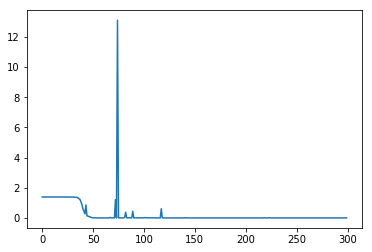

In [22]:
# %%time
model_d = model_d.train()

losses = []
batch_size = 10

batch_pbar = tqdm(range(300), desc='Batches')

for epoch in batch_pbar:
    X_batch, Y_batch = generate_nn_io(batch_size=batch_size)
    X_batch, Y_batch = to_torch(X_batch, Y_batch)
    
    with torch.no_grad():
        Y_batch_pred = model_g(X_batch)
    
    model_d.opt.zero_grad()
    real_out = model_d(Y_batch)
    fake_out = model_d(Y_batch_pred)
    loss = discriminator_loss_function_base(real_out, fake_out)
    loss.backward()
    model_d.opt.step()
    
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    batch_pbar.set_postfix({'Loss':loss})
        
plt.plot(np.arange(len(losses)), losses)

del X_batch, Y_batch, Y_batch_pred, loss, real_out, fake_out, losses


model_d = model_d.eval()

In [23]:
clear_mem(True)


total:  11.996954624
cached:  0.03145728
allocated:  0.015219712


In [24]:
with torch.no_grad():
    Y_test_pred = model_g(to_torch(X_test))

    fake_out = model_d(Y_test_pred)
    real_out = model_d(to_torch(Y_test))

    test_loss = discriminator_loss_function_base(real_out, fake_out)
    accuracy = (((fake_out<0.5).sum() + (real_out>0.5).sum())/float(len(fake_out)+len(real_out))).item()

print('Test Loss: ', test_loss)
print('Accuracy: ', accuracy)


Test Loss:  tensor(2.3175e-05, device='cuda:0')
Accuracy:  1.0


In [66]:
torch.save(model_d, 'models/disc_model.pth')

# GAN Training

In [25]:
clear_mem(True)



total:  11.996954624
cached:  0.03145728
allocated:  0.01561344


In [26]:
# %%time
model_d = model_d.train()
model_g = model_g.train()


g_losses = []
d_losses = []

batch_pbar = tqdm(range(300), desc='Batches')

batch_size = 10
for epoch in batch_pbar:
    X_batch, Y_batch = generate_nn_io(batch_size=batch_size)
    X_batch, Y_batch = to_torch(X_batch, Y_batch)
    

    # update discriminator
    model_d.opt.zero_grad()
    Y_batch_pred = model_g(X_batch)
    real_out = model_d(Y_batch)
    fake_out = model_d(Y_batch_pred)
    loss = discriminator_loss_function_base(real_out, fake_out)
    loss.backward()
    model_d.opt.step()
    
    loss = loss.item()
    d_losses.append(loss)
    batch_pbar.set_postfix({'D Loss':loss})
    
    # update generator
    model_d.opt.zero_grad()
    model_g.opt.zero_grad()
    
    Y_batch_pred = model_g(X_batch)
    loss = generator_loss_function_gan(X_batch, Y_batch, Y_batch_pred, model_d)
    loss.backward()
    model_g.opt.step()
    
    loss = loss.item()
    g_losses.append(loss)
    batch_pbar.set_postfix({'G Loss':loss})
    
del X_batch, Y_batch, Y_batch_pred, loss
    
plt.plot(np.arange(len(losses)), losses)


model_d = model_d.eval()
model_g = model_g.eval()

NameError: name 'losses' is not defined

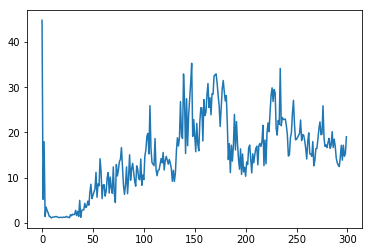

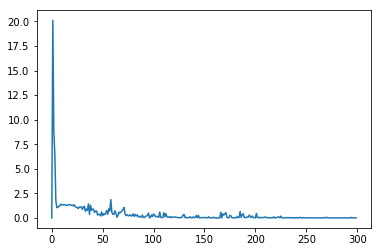

In [27]:
plt.plot(np.arange(len(g_losses)), g_losses)
plt.show()

plt.plot(np.arange(len(d_losses)), d_losses)
plt.show()



In [ ]:
clear_mem(True)

In [ ]:
show_test_example(model_g, X_test, Y_test, show_idx=0)